In [7]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt

# Set plotting style
sns.set_style('whitegrid')

# 1. Load News Data (from Task 1)
# Contains: headline, stock, date, tb_polarity, vader_compound
news_df = pd.read_csv("../data/processed/task1_processed.csv")

# 2. Load Stock Data (from Task 2)
# Contains: date_only, Daily_Return, SMA_20, RSI, MACD
TARGET_STOCK = "MRK" 
stock_df = pd.read_csv(f"../data/processed/{TARGET_STOCK}_processed_stock_data.csv")

# Convert date columns to the correct type (date object) for merging
news_df['date_only'] = pd.to_datetime(news_df['date_only']).dt.date
stock_df['date_only'] = pd.to_datetime(stock_df['date_only']).dt.date

print(f"--- Data Loaded for {TARGET_STOCK} ---")
print(f"News Dates: {news_df['date_only'].nunique()} unique days")
print(f"Stock Dates: {stock_df['date_only'].nunique()} unique days")

--- Data Loaded for MRK ---
News Dates: 2502 unique days
Stock Dates: 3489 unique days


In [9]:
# Filter news data for the target stock only (AAPL)
target_news = news_df[news_df['stock'] == TARGET_STOCK].copy()

# Group by the date and calculate the MEAN of the sentiment scores
# This creates one sentiment score per day for AAPL
daily_sentiment = target_news.groupby('date_only').agg({
    'tb_polarity': 'mean',
    'vader_compound': 'mean'
}).reset_index()

daily_sentiment.rename(columns={
    'tb_polarity': 'Daily_TB_Sentiment',
    'vader_compound': 'Daily_VADER_Sentiment'
}, inplace=True)

print("\nAggregated Daily Sentiment Head:")
print(daily_sentiment.head())
print(f"Aggregated Sentiment Days: {daily_sentiment['date_only'].nunique()}")


Aggregated Daily Sentiment Head:
    date_only  Daily_TB_Sentiment  Daily_VADER_Sentiment
0  2020-06-03            0.000000                0.00000
1  2020-06-04            0.106818                0.46890
2  2020-06-05            0.000000                0.44015
3  2020-06-07           -0.100000                0.00000
4  2020-06-09            0.400000                0.25000
Aggregated Sentiment Days: 7


In [10]:
# Merge the daily sentiment with the stock return data
# 'inner' merge ensures we only keep days where BOTH news and trading data exist.
merged_df = pd.merge(
    daily_sentiment,
    stock_df,
    on='date_only',
    how='inner' 
)
# 

# A final check for nulls (removes rows where returns might be missing, e.g., market holiday)
merged_df.dropna(inplace=True)

print("\nMerged Data Sample (Sentiment vs. Return):")
print(merged_df[['date_only', 'Daily_VADER_Sentiment', 'Daily_Return']].head())
print(f"Final Merged Days: {merged_df['date_only'].nunique()} days (This is the set of days used for correlation)")


Merged Data Sample (Sentiment vs. Return):
    date_only  Daily_VADER_Sentiment  Daily_Return
0  2020-06-03                0.00000      0.015092
1  2020-06-04                0.46890     -0.006215
2  2020-06-05                0.44015      0.008706
3  2020-06-09                0.25000     -0.007720
4  2020-06-10                0.36120     -0.005957
Final Merged Days: 6 days (This is the set of days used for correlation)


In [11]:
# We test correlation between Daily Sentiment and Daily Return

# 1. Correlation with VADER Sentiment
# pearsonr returns the correlation coefficient (r) and the p-value
vader_corr, vader_pvalue = pearsonr(merged_df['Daily_VADER_Sentiment'], merged_df['Daily_Return'])

# 2. Correlation with TextBlob Sentiment
tb_corr, tb_pvalue = pearsonr(merged_df['Daily_TB_Sentiment'], merged_df['Daily_Return'])

print(f"\n--- Correlation Results ({TARGET_STOCK}) ---")
print("Objective: Test the Null Hypothesis (H0): There is NO correlation between sentiment and returns.")

print(f"\nVADER Sentiment vs. Daily Return:")
print(f"  Correlation Coefficient (r): {vader_corr:.4f}")
print(f"  P-value: {vader_pvalue:.4f}")

print(f"\nTextBlob Sentiment vs. Daily Return:")
print(f"  Correlation Coefficient (r): {tb_corr:.4f}")
print(f"  P-value: {tb_pvalue:.4f}")


--- Correlation Results (MRK) ---
Objective: Test the Null Hypothesis (H0): There is NO correlation between sentiment and returns.

VADER Sentiment vs. Daily Return:
  Correlation Coefficient (r): -0.1866
  P-value: 0.7234

TextBlob Sentiment vs. Daily Return:
  Correlation Coefficient (r): 0.0249
  P-value: 0.9627


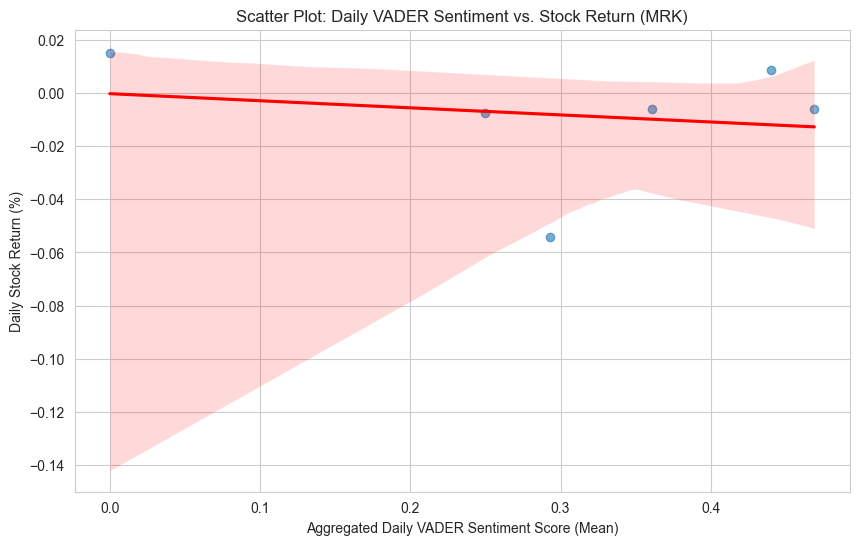

In [12]:
plt.figure(figsize=(10, 6))
sns.regplot(
    x='Daily_VADER_Sentiment', 
    y='Daily_Return', 
    data=merged_df, 
    scatter_kws={'alpha':0.6}, 
    line_kws={'color':'red'}
)
plt.title(f'Scatter Plot: Daily VADER Sentiment vs. Stock Return ({TARGET_STOCK})')
plt.xlabel('Aggregated Daily VADER Sentiment Score (Mean)')
plt.ylabel('Daily Stock Return (%)')
plt.show()